In [2]:

# remote Distributed Mode
# client = Client('tcp://192.168.2.100:8786')

# Local Multi-thread
# client = Client(processes=False, threads_per_worker=2,
#                 n_workers=2, memory_limit='2GB')

# Local Multi-Process
# client = Client(processes=True, threads_per_worker=2,
#                 n_workers=2, memory_limit='2GB')

# Local Single-Thread
client = None

(60000, 28, 28)
(10000, 28, 28)


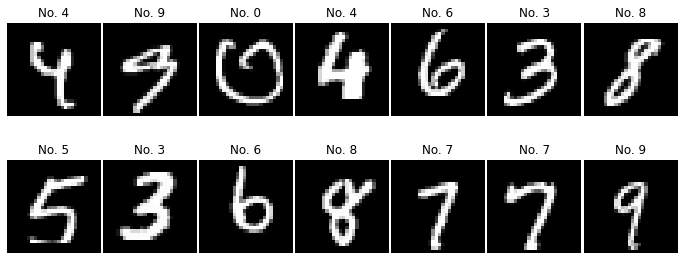

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

 # load the data - it returns 2 tuples of digits & labels - one for
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_test.shape)

# display 14 random images from the training set
np.random.seed(123)

rand_14 = np.random.randint(0, x_train.shape[0], 14)
sample_digits = x_train[rand_14]
sample_labels = y_train[rand_14]
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12, 5),
                     gridspec_kw={'wspace': 0.03, 'hspace': 0.01},
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r, c].axis("off")
        ax[r, c].imshow(sample_digits[image_index], cmap='gray')
        ax[r, c].set_title('No. %d' % sample_labels[image_index])
plt.show()
plt.close()




In [4]:
import keras
from keras import backend as K
from dpyacl.core.collections import IndexCollection
from dpyacl.core.misc.misc import split


# global configuration
batch_size = 1024
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

train_idx, test_idx, label_idx, unlabel_idx = split(
    X=X,
    y=y,
    test_ratio=0.3,
    initial_label_rate=0.05,
    split_count=1,
    all_class=True)

# convert to indexed collection
train_idx = IndexCollection(train_idx[0])
test_idx = IndexCollection(test_idx[0])
label_idx = IndexCollection(label_idx[0])
unlabel_idx = IndexCollection(unlabel_idx[0])

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from dpyacl.oracle import SimulatedOracle
from dpyacl.core.stop_criteria import MaxIteration
from dpyacl.strategies.single_label import QueryLeastConfidentSampling

# Create the learning technique
ml_technique = Sequential()
ml_technique.add(Conv2D(32, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=input_shape))
ml_technique.add(Conv2D(64, (3, 3), activation='relu'))
ml_technique.add(MaxPooling2D(pool_size=(2, 2)))
ml_technique.add(Dropout(0.25))
ml_technique.add(Flatten())
ml_technique.add(Dense(128, activation='relu'))
ml_technique.add(Dropout(0.5))
ml_technique.add(Dense(num_classes, activation='softmax'))
ml_technique.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the active learning components
stopping_criteria = MaxIteration(10)
query_strategy = QueryLeastConfidentSampling()
oracle = SimulatedOracle(labels=y)


Epoch 1/3
3/3 [==============================] - 2s 829ms/step - loss: 2.1980 - accuracy: 0.2539 - val_loss: 1.7309 - val_accuracy: 0.7337
Epoch 2/3
3/3 [==============================] - 2s 822ms/step - loss: 1.6076 - accuracy: 0.5882 - val_loss: 1.0345 - val_accuracy: 0.7600
Epoch 3/3
3/3 [==============================] - 2s 827ms/step - loss: 1.0766 - accuracy: 0.6641 - val_loss: 0.6522 - val_accuracy: 0.8178
Instruc

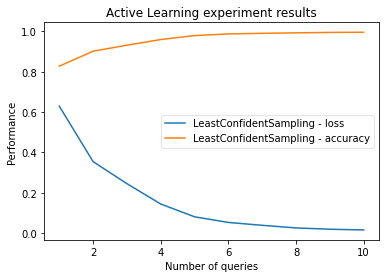

In [6]:
%%time
import time

from dpyacl.core.state import StateItem, State
from dpyacl.experiment import ExperimentAnalyserFactory

start_time = time.time()
experimentState = State(round=0,
                        train_idx=train_idx, test_idx=test_idx,
                        init_L=label_idx, init_U=unlabel_idx,
                        performance_metrics=[metric for metric in ["loss", "accuracy"]],
                        verbose=True)

while not stopping_criteria.is_stop() and len(unlabel_idx) > 0:

    label_x = X[label_idx.index, :]
    label_y = y[label_idx.index]
    test_x = X[test_idx, :]
    test_y = y[test_idx]

    # Train and evaluate Model over the labeled instances
    ml_technique.fit(label_x, label_y,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=True,
                     validation_data=(test_x, test_y))

    # predict the results over the labeled test instances
    label_pred = ml_technique.predict_classes(test_x)

    # performance calc for all metrics
    label_perf = []
    score = ml_technique.evaluate(x_test, y_test, verbose=1)

    label_perf.append({"name": "loss", "value": score[0]})
    label_perf.append({"name": "accuracy", "value": score[1]})

    # use the query strategy for selecting the indexes
    select_ind = query_strategy.select(X=X,
                                       y=y,
                                       label_index=label_idx,
                                       unlabel_index=unlabel_idx,
                                       batch_size=batch_size,
                                       model=ml_technique,
                                       client=client
                                       )

    # show label values
    oracle.query(instances=X[select_ind], indexes=select_ind)

    # update label and unlabel instaces
    label_idx.update(select_ind)
    unlabel_idx.difference_update(select_ind)

    # save intermediate results
    experimentState.add_state(
        StateItem(select_index=select_ind,
                  performance_metrics=[metric['name'] for metric in label_perf],
                  performance=label_perf))

    # update stopping_criteria
    stopping_criteria.update_information(experimentState)

end_time = time.time() - start_time
print(end_time)

query_analyser = ExperimentAnalyserFactory.experiment_analyser(
    performance_metrics=[metric for metric in ["loss", "accuracy"]],
    method_name=query_strategy.query_function_name,
    method_results=[experimentState],
    type="queries"
)

# get a brief description of the experiment
query_analyser.plot_learning_curves(title='Active Learning experiment results')